In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
from lifelines import CoxPHFitter
import numpy as np
import pandas as pd

## Testing the proportional hazard assumptions

This Jupyter notebook is a small tutorial on how to test and fix proportional hazard problems. An important question to first ask is: [_do I need to care about the proportional hazard assumption?_](#Do-I-need-to-care-about-the-proportional-hazard-assumption?) - often the answer is no. 

The proportional hazard assumption is that _all_ individuals have the same hazard function, but a unique scaling factor infront. So the _shape_ of the hazard function is the same for all individuals, and only a scalar multiple changes per individual. 

$$h_i(t) = a_i h(t)$$

At the core of the assumption is that $a_i$ is not time varying, that is, $a_i(t) = a_i$. Further more, if we take the ratio of this with another subject (called the hazard ratio): 

$$\frac{h_i(t)}{h_j(t)} = \frac{a_i h(t)}{a_j h(t)} = \frac{a_i}{a_j}$$

is constant for all $t$. In this tutorial we will test this non-time varying assumption, and look at ways to handle violations. 


In [2]:
from lifelines.datasets import load_rossi
rossi = load_rossi()
cph = CoxPHFitter()

cph.fit(rossi, 'week', 'arrest')

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>

In [3]:
cph.print_summary(model="untransformed variables", decimals=3)

### Checking assumptions with `check_assumptions`

New to lifelines 0.16.0 is the `CoxPHFitter.check_assumptions` method. This method will compute statistics that check the proportional hazard assumption, produce plots to check assumptions, and more. Also included is an option to display advice to the console. Here's a breakdown of each information displayed:

 - Presented first are the results of a statistical test to test for any time-varying coefficients. A time-varying coefficient imply a covariate's influence _relative to the baseline_ changes over time. This implies a violation of the proportional hazard assumption. For each variable, we transform _time_ four times (these are common transformations of time to perform). If _lifelines_ rejects the null (that is, _lifelines_ rejects that the coefficient is not time-varying), we report this to the user.
 - Some advice is presented on how to correct the proportional hazard violation based on some summary statistics of the variable. 
 - As a compliment to the above statistical test, for each variable that violates the PH assumption, visual plots of the the _scaled Schoenfeld residuals_ is presented against the four time transformations. A fitted lowess is also presented, along with 10 bootstrapped lowess lines (as an approximation to the confidence interval of the original lowess line). Ideally, this lowess line is constant (flat). Deviations away from the constant line are violations of the PH assumption. 
 
####  Why the _scaled Schoenfeld residuals_?
 
This section can be skipped on first read. Let $s_{t,j}$ denote the scaled Schoenfeld residuals of variable $j$ at time $t$, $\hat{\beta_j}$ denote the maximum-likelihood estimate of the $j$th variable, and $\beta_j(t)$ a time-varying coefficient in (fictional) alternative model that allows for time-varying coefficients. Therneau and Grambsch showed that. 

$$E[s_{t,j}] + \hat{\beta_j} = \beta_j(t)$$

The proportional hazard assumption implies that $\hat{\beta_j} = \beta_j(t)$, hence $E[s_{t,j}] = 0$. This is what the above proportional hazard test is testing. Visually, plotting $s_{t,j}$ over time (or some transform of time), is a good way to see violations of $E[s_{t,j}] = 0$, along with the statisical test. 

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.





1. Variable 'age' failed the non-proportional test: p-value is 0.0007.

   Advice 1: the functional form of the variable 'age' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'age' using pd.cut, and then specify it in `strata=['age',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'wexp' failed the non-proportional test: p-value is 0.0063.

   Advice: with so few unique values (only 2), you can include `strata=['wexp', ...]` in the call in
`.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/lat

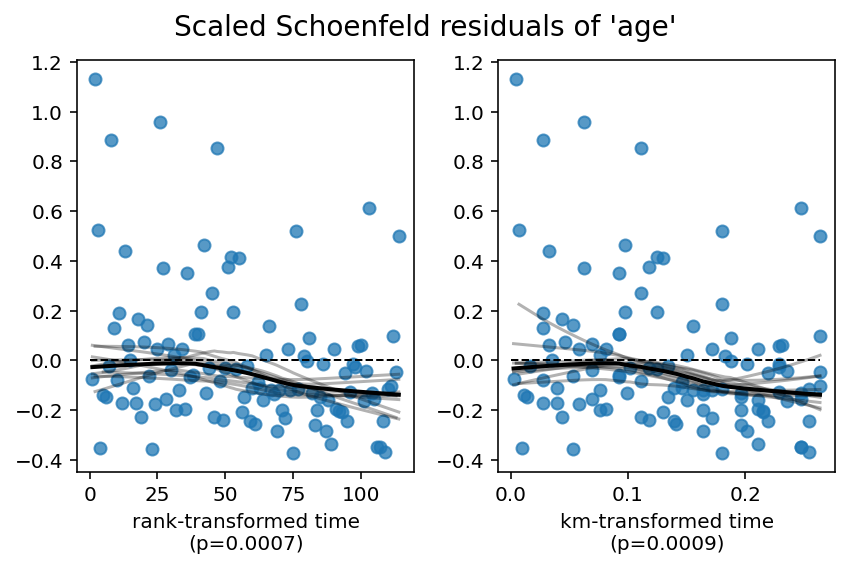

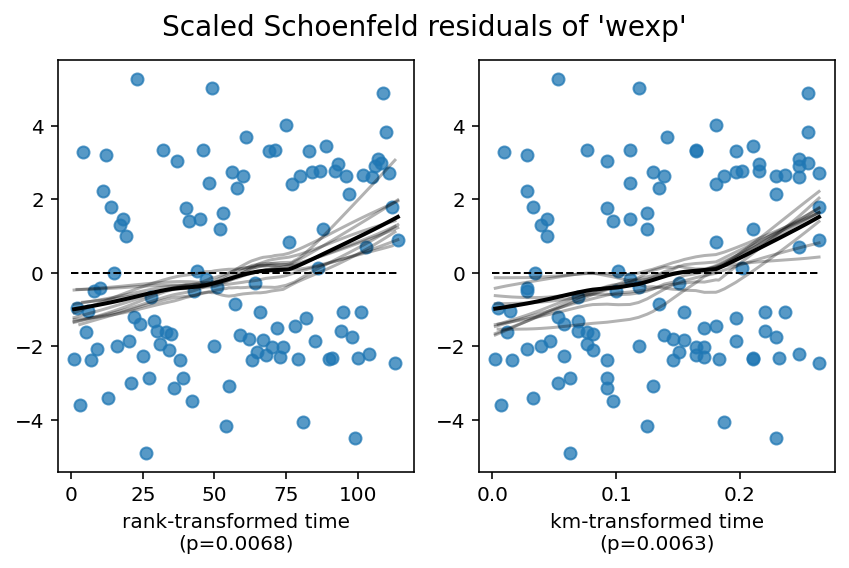

In [4]:
cph.check_assumptions(rossi, p_value_threshold=0.05, show_plots=True)

Alternatively, you can use the proportional hazard test outside of `check_assumptions`:

In [5]:
from lifelines.statistics import proportional_hazard_test

results = proportional_hazard_test(cph, rossi, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

#### Stratification


In the advice above, we can see that `wexp` has small cardinality, so we can easily fix that by specifying it in the `strata`. What does the `strata` do? Let's go back to the proportional hazard assumption.

In the introduction, we said that the proportional hazard assumption was that 

$$ h_i(t) = a_i h(t)$$

In a simple case, it may be that there are two subgroups that have _very_ different baseline hazards. That is, we can split the dataset into subsamples based on some variable (we call this the stratifying variable), run the Cox model on all subsamples, and compare their baseline hazards. If these baseline hazards are _very_ different, then clearly the formula above is wrong - the $h(t)$ is some weighted average of the subgroups' baseline hazards. This ill fitting average baseline can cause $a_i$ to have time-dependent influence. A better model might be:

$$ h_{i |i\in G}(t) = a_i h_G(t)$$

where now we have a unique baseline hazard _per_ subgroup $G$. Because of the way the Cox model is designed, inference of the coefficients is identical (expect now there are more baseline hazards, and no variation of the stratifying variable within a subgroup $G$). 


In [6]:
cph.fit(rossi, 'week', 'arrest', strata=['wexp'])
cph.print_summary(model="wexp in strata")

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.





1. Variable 'age' failed the non-proportional test: p-value is 0.0008.

   Advice 1: the functional form of the variable 'age' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'age' using pd.cut, and then specify it in `strata=['age',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varyi

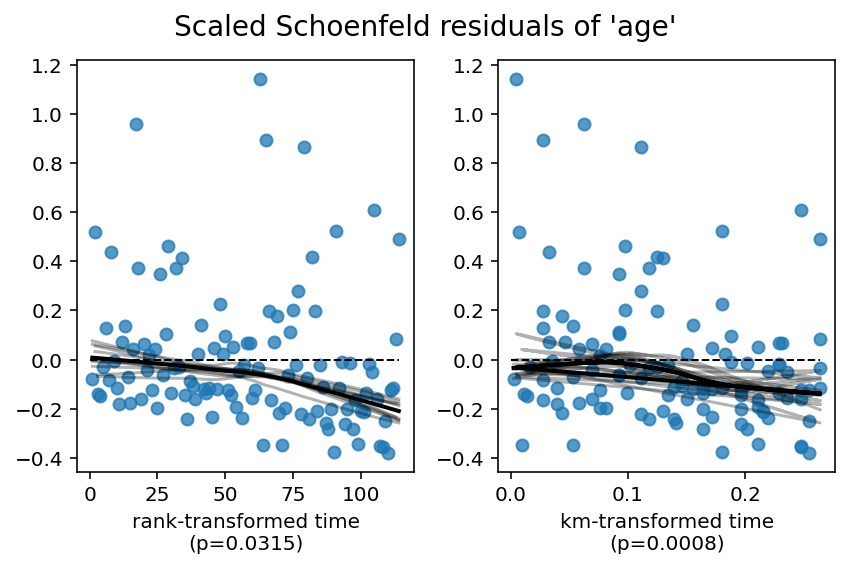

In [7]:
cph.check_assumptions(rossi, show_plots=True)

Since `age` is still violating the proportional hazard assumption, we need to model it better.  From the residual plots above, we can see a the effect of age start to become negative over time. This will be relevant later. Below, we present three options to handle `age`. 

#### Modify the functional form

The proportional hazard test is very sensitive (i.e. lots of false positives) when the functional form of a variable is incorrect. For example, if the association between a covariate and the log-hazard is non-linear, but the model has only a linear term included, then the proportional hazard test can raise a false positive. 

The modeller can choose to add quadratic or cubic terms, i.e:
```
rossi['age**2'] = (rossi['age'] - rossi['age'].mean())**2
rossi['age**3'] = (rossi['age'] - rossi['age'].mean())**3
```

but I think a more correct way to include non-linear terms is to use splines. Both Patsy and zEpid provide functionality for splines (tutorial incoming), but let's stick with the form above. 



The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.





1. Variable 'age' failed the non-proportional test: p-value is 0.0008.

   Advice 1: the functional form of the variable 'age' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'age' using pd.cut, and then specify it in `strata=['age',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varyi

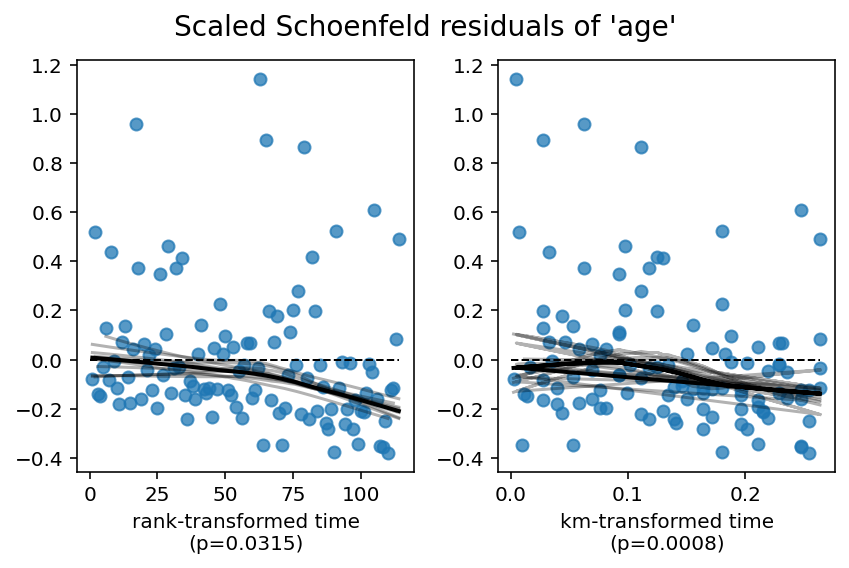

In [8]:
rossi_higher_order_age = rossi.copy()
rossi_higher_order_age['age'] = rossi_higher_order_age['age'] - rossi_higher_order_age['age'].mean()
rossi_higher_order_age['age**2'] = (rossi_higher_order_age['age'] - rossi_higher_order_age['age'].mean())**2
rossi_higher_order_age['age**3'] = (rossi_higher_order_age['age'] - rossi_higher_order_age['age'].mean())**3

cph.fit(rossi_higher_order_age, 'week', 'arrest', strata=['wexp'])
cph.print_summary(model="quad and cubic age terms"); print()
cph.check_assumptions(rossi_higher_order_age, show_plots=True, p_value_threshold=0.05)

We see we still have potentially _some_ violation, but it's a heck of a lot less. Also, interestingly, when we include these non-linear terms for `age`, the `wexp` proportionality violation disappears. It is not uncommon to see changing the functional form of one variable effects other's proportional tests, usually positively. So, we could remove the `strata=['wexp']` if we wished. 

#### Bin variable and stratify on it


The second option proposed is to bin the variable into equal-sized bins, and stratify like we did with `wexp`. There is a trade off here between estimation and information-loss. If we have large bins, we will lose information (since different values are now binned together), but we need to estimate less new baseline hazards. On the other hand, with tiny bins, we allow the `age` data to have the most "wiggle room", but must compute many baseline hazards each of which has a smaller sample size. Like most things, the optimial value is somewhere inbetween.

In [9]:
rossi_strata_age = rossi.copy()
rossi_strata_age['age_strata'] = pd.cut(rossi_strata_age['age'], np.arange(0, 80, 3))

rossi_strata_age[['age', 'age_strata']].head()

,age,age_strata
0,27,"(24, 27]"
1,18,"(15, 18]"
2,19,"(18, 21]"
3,23,"(21, 24]"
4,19,"(18, 21]"


In [10]:
# drop the orignal, redundant, age column
rossi_strata_age = rossi_strata_age.drop('age', axis=1)
cph.fit(rossi_strata_age, 'week', 'arrest', strata=['age_strata', 'wexp'])

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>

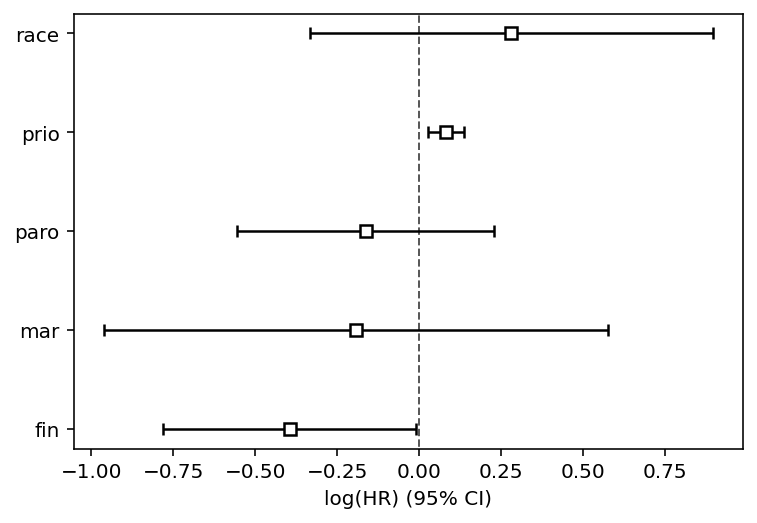

In [11]:
cph.print_summary(3, model="stratified age and wexp")
cph.plot()

In [12]:
cph.check_assumptions(rossi_strata_age)

Proportional hazard assumption looks okay.


#### Introduce time-varying covariates

Our second option to correct variables that violate the proportional hazard assumption is to model the time-varying component directly. This is done in two steps. The first is to transform your dataset into _episodic format_. This means that we split a subject from a single row into $n$ new rows, and each new row represents some time period for the subject. It's okay that the variables are static over this new time periods - we'll introduce some time-varying covariates later.

See below for how to do this in _lifelines_:

In [13]:
from lifelines.utils import to_episodic_format

# the time_gaps parameter specifies how large or small you want the periods to be. 
rossi_long = to_episodic_format(rossi, duration_col='week', event_col='arrest', time_gaps=1.)
rossi_long.head(25)


,stop,start,arrest,age,fin,id,mar,paro,prio,race,wexp
0,1.0,0.0,0,27,0,0,0,1,3,1,0
1,2.0,1.0,0,27,0,0,0,1,3,1,0
2,3.0,2.0,0,27,0,0,0,1,3,1,0
3,4.0,3.0,0,27,0,0,0,1,3,1,0
4,5.0,4.0,0,27,0,0,0,1,3,1,0
5,6.0,5.0,0,27,0,0,0,1,3,1,0
6,7.0,6.0,0,27,0,0,0,1,3,1,0
7,8.0,7.0,0,27,0,0,0,1,3,1,0
8,9.0,8.0,0,27,0,0,0,1,3,1,0
9,10.0,9.0,0,27,0,0,0,1,3,1,0


Each subject is given a new id (but can be specified as well if already provided in the dataframe). This id is used to track subjects over time. Notice the `arrest` col is 0 for all periods prior to their (possible) event as well. 

Above I mentioned there were two steps to correct `age`. The first was to convert to a episodic format. The second is to create an interaction term between `age` and `stop`. This is a time-varying variable.

Instead of `CoxPHFitter`, we must use `CoxTimeVaryingFitter` instead since we are working with a episodic dataset. 

In [14]:
rossi_long['time*age'] = rossi_long['age'] * rossi_long['stop']

In [15]:
from lifelines import CoxTimeVaryingFitter
ctv = CoxTimeVaryingFitter()

ctv.fit(rossi_long, 
        id_col='id', 
        event_col='arrest', 
        start_col='start', 
        stop_col='stop', 
        strata=['wexp'])

<lifelines.CoxTimeVaryingFitter: fitted with 19809 periods, 432 subjects, 114 events>

In [16]:
ctv.print_summary(3, model="age * time interaction")

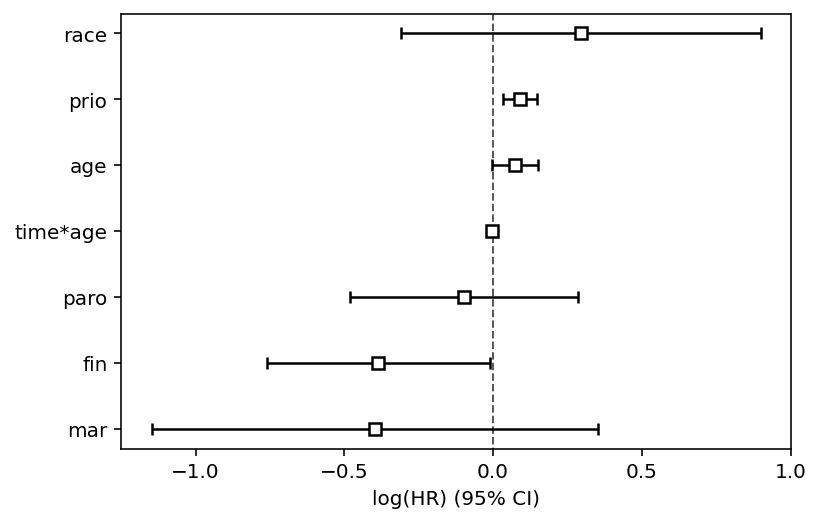

In [17]:
ctv.plot()

In the above scaled Schoenfeld residual plots for `age`, we can see there is a slight negative effect for higher time values. This is confirmed in the output of the `CoxTimeVaryingFitter`: we see that the coefficient for `time*age` is -0.005.

#### Conclusion

The point estimates and the standard errors are very close to each other using either option, we can feel confident that either approach is okay to proceed. 

## Do I need to care about the proportional hazard assumption?

You may be surprised that often you don't need to care about the proportional hazard assumption. There are many reasons why not:

1. If your goal is survival prediction, then you don't need to care about proportional hazards. Your goal is to maximize some score, irrelevant of how predictions are generated. 

2. Given a large enough sample size, even very small violations of proportional hazards will show up.  

3. There are legitimate reasons to assume that all datasets will violate the proportional hazards assumption. This is detailed well in Stensrud & Hernán's "Why Test for Proportional Hazards?" [1]. 

Given the above considerations, the status quo is still to check for proportional hazards. So if you are avoiding testing for proportional hazards, be sure to understand and able to answer _why_ you are avoiding testing. 


1.  Stensrud MJ, Hernán MA. Why Test for Proportional Hazards? JAMA. Published online March 13, 2020. doi:10.1001/jama.2020.1267